**MARKET RISKS PROJECT - GROUP 7**

**TRADING STRATEGY (MSFT – January 30, 2026)**

On January 30, 2026, with Microsoft (MSFT) trading at S0 = 430.29, our group structured an OTC options portfolio composed of five different strategies, with two different maturities, as follow:


T1: 20/02/2026

1. Short straddle:

*  short call with K = 430
*  short put with K = 430

2. Short strangle:


*   short put with K = 410
*   short call with K = 450

T2: 18/06/2026

3. Short put spread
*  short put with K = 430
*  long put with K = 410

4. Short call spread
*  short call with K = 430
*  long call with K = 450

5. Short strangle
*  short put with K = 385
*  short call with K = 475

To price these OTC positions, our team applied the Black&Scholes framework and derived the implied volatilities by interpolating them from the listed options’ implied volatility surface observed in the market. The risk-free rate was aligned with the relevant maturities (approximately 3.72% for February and 3.6699% for June), while the dividend yield was set to q = 0.00787. The resulting time-to-maturity parameters are T = 0.084 (20/02/2026) and T = 0.556 (18/06/2026).


**Adjustment through listed options**

In order to reshape the portfolio exposures, the desk also traded the following listed options, with two different maturities:

T1: 20/02/2026
*   Long put with K=430
*   Long call with K=430

T2: 18/06/2026

* Long put with K=430
* Long call with K=430
* Short call with K=475

In the dataset the quantity of the options already embeds the position sign, therefore the portfolio value and Greeks are computed by sum (units * metrics). We first quantify the unhedged options exposures, then we implement a delta hedge with the underlying to neutralize irectional risk while keeping gamma, vega, and theta in the book.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d, interp2d
import scipy.stats as stats
import yfinance as yf
import pandas_datareader.data as pdr
import re
import math
import yfinance as yf

**Defining Formulas**

In [2]:
#Black & Scholes formulas
#Pricing & Greeks

def BS_Call_Pricing(S0, K, r, sigma, q, T):
  d1 = (np.log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  return  np.max(S0*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2),0)

def BS_Put_Pricing(S0, K, r, sigma, q, T):
  d1 = (np.log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  return np.max(K*np.exp(-r*T)*norm.cdf(-d2) - S0*np.exp(-q*T)*norm.cdf(-d1),0)

def Delta_Call(S0, K, r, sigma, q, T):
  d1 = (np.log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*np.sqrt(T))
  return  np.exp(-q*T)*norm.cdf(d1)

def Delta_Put(S0, K, r, sigma, q, T):
  d1 = (np.log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*np.sqrt(T))
  return  np.exp(-q*T)*(norm.cdf(d1) - 1)

def Gamma(S0, K, r, sigma, q, T):
  d1 = (np.log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*np.sqrt(T))
  return  (np.exp(-q*T)*norm.pdf(d1)) / (S0*sigma*np.sqrt(T))

def Vega(S0, K, r, sigma, q, T):
  d1 = (np.log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*np.sqrt(T))
  return  S0*np.exp(-q*T)*np.sqrt(T)*norm.pdf(d1)

# Theta

def Theta_Call(S0, K, r, sigma, q, T):
  d1 = (np.log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  return  -(S0*np.exp(-q*T)*norm.pdf(d1)*sigma)/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2)
  + q*S0*np.exp(-q*T)*norm.cdf(d1)

def Theta_Put(S0, K, r, sigma, q, T):
  d1 = (np.log(S0/K) +(r-q+sigma**2/2)*T )/(sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  return  -(S0*np.exp(-q*T)*norm.pdf(d1)*sigma)/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2)
  - q*S0*np.exp(-q*T)*norm.cdf(-d1)

# Portfolio Value Calculation:

def Hedged_portfolio_value(df1, S, date, delta_hedge):
  df = df1.copy()
  df['today'] = date
  df['T'] = (df['maturity'] - df['today']).dt.days/250
  df['S0'] = S
  df['price'] = df.apply(lambda row: BS_Call_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else BS_Put_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['delta'] = df.apply(lambda row: Delta_Call(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else Delta_Put(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['gamma'] = df.apply(lambda row: Gamma(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['vega'] = df.apply(lambda row: Vega(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)/100

  return (df['price']*df['units']).sum() - delta_hedge * S

def Hedged_portfolio_value_vol(df1, volchange, date, delta_hedge):
  df = df1.copy()
  df['today'] = date
  df['T'] = (df['maturity'] - df['today']).dt.days/250
  df['vol'] = df['vol'] * volchange
  df['price'] = df.apply(lambda row: BS_Call_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else BS_Put_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['delta'] = df.apply(lambda row: Delta_Call(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else Delta_Put(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['gamma'] = df.apply(lambda row: Gamma(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['vega'] = df.apply(lambda row: Vega(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)/100

  return (df['price']*df['units']).sum() - delta_hedge * S
def Hedged_portfolio_value_both(df1, S, volchange, date, delta_hedge):
  df = df1.copy()
  df['today'] = date
  df['T'] = (df['maturity'] - df['today']).dt.days/250
  df['S0'] = S
  df['vol'] = df['vol'] + volchange
  df['price'] = df.apply(lambda row: BS_Call_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else BS_Put_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['delta'] = df.apply(lambda row: Delta_Call(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else Delta_Put(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['gamma'] = df.apply(lambda row: Gamma(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
  df['vega'] = df.apply(lambda row: Vega(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)/100

  return (df['price']*df['units']).sum() - delta_hedge * S


def Ptf_features(df):
    delta = (df['units'] * df['delta']).sum()
    gamma = (df['units'] * df['gamma']).sum()
    vega  = (df['units'] * df['vega']).sum()
    theta = (df['units'] * df['theta']).sum()
    value = (df['units'] * df['price']).sum()
    return delta, gamma, vega, theta, value

In [3]:
FILE = '/content/Strategy_7-2.xlsx'

S0 = 430.29
OTC = pd.read_excel(FILE, sheet_name='OTC')
listed = pd.read_excel(FILE, sheet_name='Traded')

OTC['maturity'] = pd.to_datetime(OTC['maturity'])
listed['maturity'] = pd.to_datetime(listed['maturity'])

quantity_multiplier = 1/12.5

OTC['units'] = OTC['units'] * quantity_multiplier
listed['units'] = listed['units'] * quantity_multiplier

OTC['S0']=S0
valuation_date = datetime(2026,1,30)
OTC['today'] = valuation_date
OTC['T'] = (OTC['maturity'] - OTC['today']).dt.days / 250

listed['S0']=S0
listed['today'] = valuation_date
listed['T'] = (listed['maturity'] - listed['today']).dt.days / 250

OTC = OTC.dropna()
listed = listed.dropna()

In [4]:
OTC

,strategy,position,type,k,maturity,r,vol,q,units,S0,today,T
0,OTC,Long,call,430,2026-02-20,0.037200,0.2444,0.00787,8.0,430.29,2026-01-30,0.084
1,OTC,Long,put,430,2026-02-20,0.037200,0.2407,0.00787,8.0,430.29,2026-01-30,0.084
2,OTC,Long,put,410,2026-02-20,0.037200,0.2574,0.00787,8.0,430.29,2026-01-30,0.084
3,OTC,Long,call,450,2026-02-20,0.037200,0.2436,0.00787,8.0,430.29,2026-01-30,0.084
4,OTC,Long,put,430,2026-06-18,0.036699,0.2771,0.00787,8.0,430.29,2026-01-30,0.556
5,OTC,short,put,410,2026-06-18,0.036699,0.2830,0.00787,-8.0,430.29,2026-01-30,0.556
6,OTC,short,call,430,2026-06-18,0.036699,0.2900,0.00787,-8.0,430.29,2026-01-30,0.556
7,OTC,long,call,450,2026-06-18,0.036699,0.2821,0.00787,8.0,430.29,2026-01-30,0.556
8,OTC,long,put,385,2026-06-18,0.036699,0.2949,0.00787,8.0,430.29,2026-01-30,0.556
9,OTC,long,call,475,2026-06-18,0.036699,0.2788,0.00787,8.0,430.29,2026-01-30,0.556


In [5]:
listed

,strategy,position,type,k,maturity,r,vol,q,units,S0,today,T
0,Traded,short,put,430,2026-02-20,0.037200,0.2444,0.00787,-8.0,430.29,2026-01-30,0.084
1,Traded,short,call,430,2026-02-20,0.037200,0.2407,0.00787,-8.0,430.29,2026-01-30,0.084
2,Traded,short,put,430,2026-06-18,0.036699,0.2771,0.00787,-8.0,430.29,2026-01-30,0.556
3,Traded,short,call,430,2026-06-18,0.036699,0.2900,0.00787,-8.0,430.29,2026-01-30,0.556
4,Traded,long,call,475,2026-06-18,0.036699,0.2788,0.00787,20.0,430.29,2026-01-30,0.556


In [6]:
#Analyzing the greeks for the OTC
OTC['price'] = OTC.apply(lambda row: BS_Call_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else BS_Put_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
OTC['delta'] = OTC.apply(lambda row: Delta_Call(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else Delta_Put(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
OTC['gamma'] = OTC.apply(lambda row: Gamma(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
OTC['vega'] = OTC.apply(lambda row: Vega(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)/100
OTC['theta'] = OTC.apply(lambda row: Theta_Call(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else Theta_Put(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)

In [7]:
#Analyzing the greeks for the Listed
listed['price'] = listed.apply(lambda row: BS_Call_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else BS_Put_Pricing(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
listed['delta'] = listed.apply(lambda row: Delta_Call(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else Delta_Put(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
listed['gamma'] = listed.apply(lambda row: Gamma(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)
listed['vega'] = listed.apply(lambda row: Vega(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)/100
listed['theta'] = listed.apply(lambda row: Theta_Call(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T'])
                       if row['type'] == 'call'
                       else Theta_Put(row['S0'], row['k'], row['r'], row['vol'], row['q'], row['T']), axis=1)

**Portfolio metrics and delta hedging**

To delta-hedge the position, after computing the relevant risk measures of the aggregate portfolio, the group shorted 7 MSFT shares, rounding the theoretical hedge ratio of 6.61 shares to the nearest tradable unit. This leaves a small residual delta of approximately −0.39.


In [8]:
# Total Portfolio features

strategy = pd.concat([OTC, listed], ignore_index=True)

delta_tot, gamma_tot, vega_tot, theta_tot, value_tot = Ptf_features(strategy)

print('----- Total Options Portfolio -----')
print(f'Value: {value_tot:.2f}')
print(f'Delta: {delta_tot:.2f}')
print(f'Gamma: {gamma_tot:.2f}')
print(f'Vega: {vega_tot:.2f}')
print(f'Theta: {theta_tot:.2f}')

----- Total Options Portfolio -----
Value: 215.80
Delta: 6.61
Gamma: 0.25
Vega: 29.45
Theta: -1626.75


In [9]:
# Valuation Date Features
V0_options = np.sum(strategy['units'] * strategy['price']) #Options value at valuation date

delta_tot = np.sum(strategy['units'] * strategy['delta']) #Delta hedge
stock_position = -delta_tot

V0_total = V0_options + stock_position * S0 #Total portfolio

print('----- Values at Valuation Date -----')
print(f'Options: {V0_options:.2f}')
print(f'Stock: {stock_position:.2f}')
print(f'Total Portfolio: {V0_total:.2f}')

----- Values at Valuation Date -----
Options: 215.80
Stock: -6.61
Total Portfolio: -2630.04


In [10]:
# Hedged Portfolio Features

stock_position = -delta_tot
delta_hedged = delta_tot + stock_position

value_hedged = value_tot + stock_position * S0

print('----- Hedged Portfolio Features -----')
print(f'Portfolio Value: {value_hedged:.2f}')
print(f'Delta: {delta_hedged:.2f}')
print(f'Gamma: {gamma_tot:.2f}')
print(f'Vega: {vega_tot:.2f}')
print(f'Theta: {theta_tot:.2f}')

----- Hedged Portfolio Features -----
Portfolio Value: -2630.04
Delta: 0.00
Gamma: 0.25
Vega: 29.45
Theta: -1626.75


**PLOT P&L VS UNDERLYING STOCK**

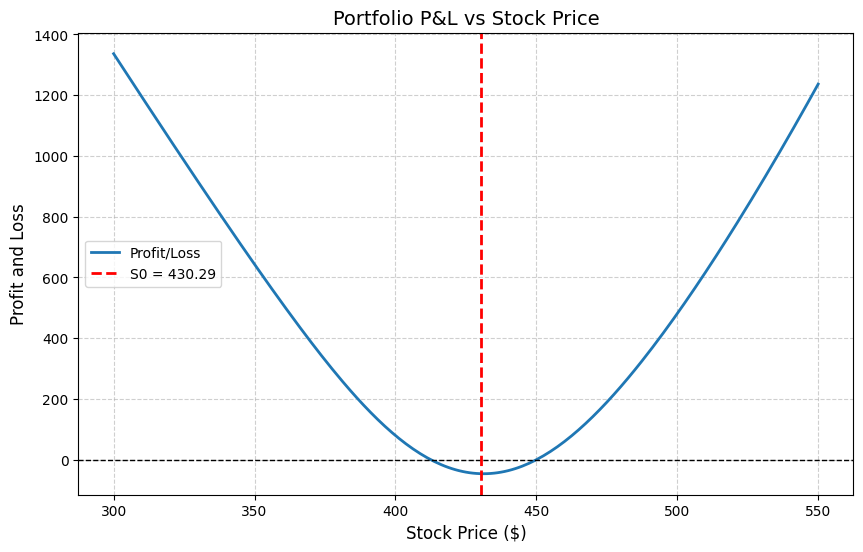

In [11]:
#PLOT P&L VS UNDERLYING STOCK
s = np.linspace(300,550,201)
value = np.zeros(len(s))
end = datetime(2026,2,6)

for i in range(len(s)):
  value[i] = Hedged_portfolio_value(strategy, s[i], end, delta_tot)
p_l = value - value_hedged
plt.figure(figsize=(10, 6))
plt.plot(s, p_l, linewidth=2, label='Profit/Loss')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(S0, color='red', linestyle='--', linewidth=2, label=f'S0 = {S0}')
plt.xlabel('Stock Price ($)', fontsize=12)
plt.ylabel('Profit and Loss', fontsize=12)
plt.title('Portfolio P&L vs Stock Price', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

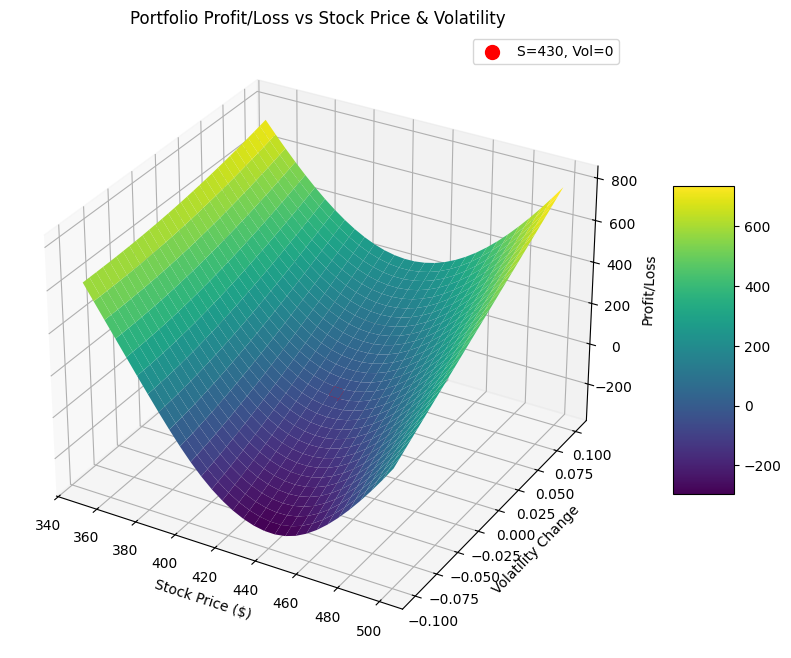

In [12]:
#P&L, Stock Price and Volatility

s = np.linspace(350,500,30)
vol = np.linspace(-0.1,0.1,30)
value = np.zeros((len(s),len(vol)))
end = datetime(2026,2,6)
for i in range(len(s)):
  for j in range(len(vol)):
    value[i,j] = Hedged_portfolio_value_both(strategy, s[i], vol[j], end, delta_tot)
P_L = value - value_hedged

S_grid, vol_grid = np.meshgrid(s, vol)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Ensure P&L is correctly transposed if needed
surf = ax.plot_surface(S_grid, vol_grid, P_L.T, cmap='viridis', edgecolor='none')

# highlights the specific point where vol = 0 and S = 430
hl_x = 430
hl_y = 0
hl_z = Hedged_portfolio_value_both(strategy, hl_x, hl_y, end, delta_tot) - value_hedged
ax.scatter(hl_x, hl_y, hl_z, color='red', s=100, label='S=430, Vol=0' )

ax.set_xlabel('Stock Price ($)')
ax.set_ylabel('Volatility Change')
ax.set_zlabel('Profit/Loss')
ax.set_title('Portfolio Profit/Loss vs Stock Price & Volatility')
ax.legend()

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

**Montecarlo Analysis**

The group performed a simulation of MSFT over a short horizon using a GBM approximation and repirce the full hedged portfolio under each simulated spot scenario.

Volatility proxy:
We used a market-implied proxy (VIX) as a simplified volatility input.



[*********************100%***********************]  1 of 1 completed


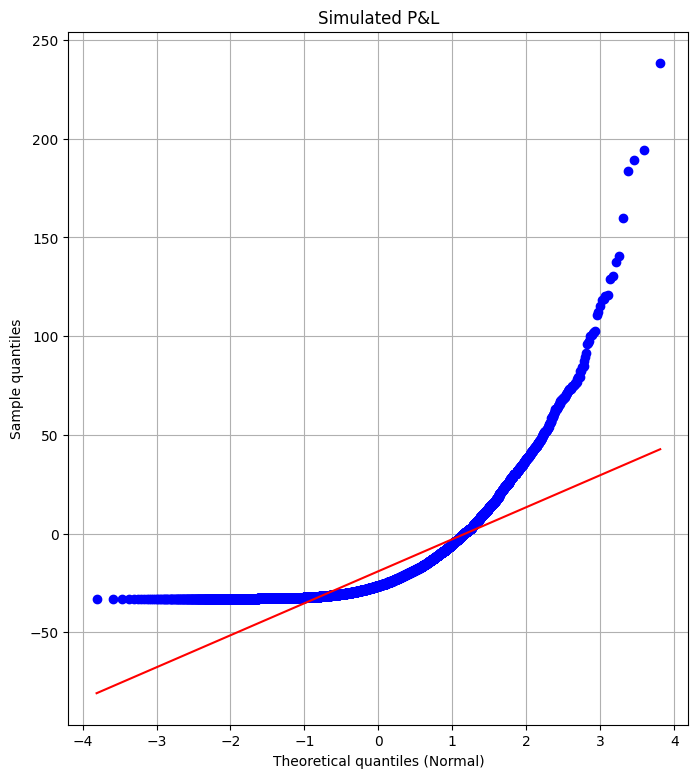

In [13]:
#MONTECARLO simulation

np.random.seed(6)
n_sims = 10000
horizon_days = 5
dt = horizon_days / 250

r_3m_df = pdr.DataReader('DGS3MO', 'fred', start=valuation_date, end= valuation_date + pd.Timedelta(days=1)).ffill()
r_3m = float(r_3m_df.iloc[0].iloc[0])/100
VIX_df=yf.download('^VIX', start=pd.to_datetime('2025-01-30'), end= valuation_date + pd.Timedelta(days=1), auto_adjust=True, )['Close']
VIX_median=np.median(VIX_df)/100   #VIX median over 12 months


def BS_Price_Vector(type_vec, S_mat, K_vec, r_vec, sigma_vec, q_vec, T_vec):
    # --- to arrays
    type_vec  = np.asarray(type_vec)
    K_vec     = np.asarray(K_vec, dtype=float)[None, :]     # (1, n_opt)
    T_vec     = np.asarray(T_vec, dtype=float)[None, :]
    r_vec     = np.asarray(r_vec, dtype=float)[None, :]
    sigma_vec = np.asarray(sigma_vec, dtype=float)[None, :]

    S_mat = np.asarray(S_mat, dtype=float)
    if S_mat.ndim == 0:
        S_mat = S_mat.reshape(1, 1)
    elif S_mat.ndim == 1:
        S_mat = S_mat.reshape(-1, 1)

    T_vec = np.maximum(T_vec, 1e-8)
    sigma_vec = np.maximum(sigma_vec, 1e-8)

    sqrtT = np.sqrt(T_vec)
    d1 = (np.log(S_mat / K_vec) + (r_vec - q + 0.5 * sigma_vec**2) * T_vec) / (sigma_vec * sqrtT)
    d2 = d1 - sigma_vec * sqrtT

    #Call/Put prices
    call = S_mat*np.exp(-q*T_vec)*norm.cdf(d1) - K_vec*np.exp(-r_vec*T_vec)*norm.cdf(d2)
    put  = K_vec*np.exp(-r_vec*T_vec)*norm.cdf(-d2) - S_mat*np.exp(-q*T_vec)*norm.cdf(-d1)

    is_call = (type_vec.astype(str).astype(object) == 'call')[None, :]
    price = np.where(is_call, call, put)
    return price


#Parametric simulation through Geometric Brownian Motion (GBM)
Z = np.random.standard_normal(n_sims)
S_sim = S0 * np.exp((r_3m - 0.5*VIX_median**2)*dt + VIX_median*np.sqrt(dt)*Z)

S_sim_mat = S_sim[:, np.newaxis]
K_vec = strategy['k'].values.astype(float)
T_new_vec = (strategy['T'].values - dt).astype(float)
type_vec = strategy['type'].values
qty_arr = strategy['units'].values
r0_vec=strategy['r'].values
sigma0_vec=strategy['vol'].values
q= OTC['q'].values[0]

prices_sim = BS_Price_Vector(type_vec, S_sim_mat, K_vec, r0_vec, sigma0_vec, q, T_new_vec) #Pricing simulated options

opt_val_sim = np.sum(prices_sim * qty_arr, axis=1)

stock_value_sim = stock_position * S_sim


ptf_value_sim = opt_val_sim + stock_value_sim
P_L_sim = ptf_value_sim - V0_total

# VaR 95% & ES 97.5%
VaR_95 = np.percentile(P_L_sim, 5)
ES_thresh = np.percentile(P_L_sim, 2.5)
ES_975 = P_L_sim[P_L_sim <= ES_thresh].mean()

VaR_Loss = -VaR_95 if VaR_95 < 0 else 0
ES_Loss = -ES_975 if ES_975 < 0 else 0

#Q-Q Plot
plt.figure(figsize=(8, 9))
stats.probplot(P_L_sim, dist='norm', plot=plt)
plt.title('Simulated P&L')
plt.xlabel('Theoretical quantiles (Normal)')
plt.ylabel('Sample quantiles')
plt.grid(True)
plt.show()

plt.style.use('seaborn-v0_8-whitegrid')

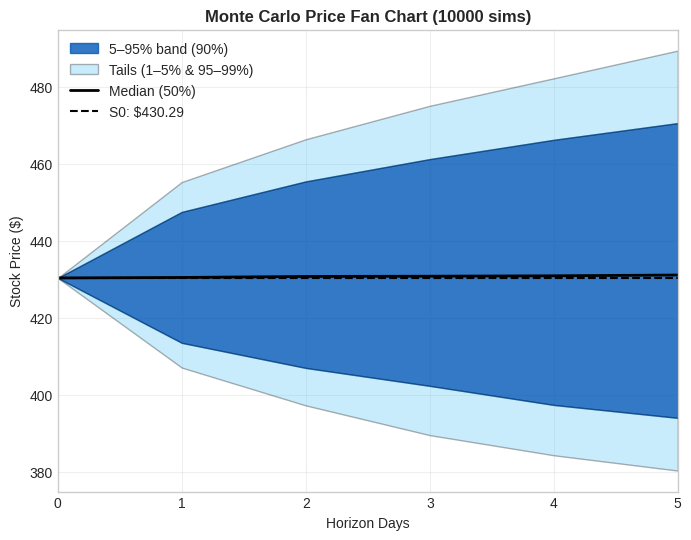

In [14]:
S_paths = np.zeros((horizon_days + 1, n_sims))
S_paths[0] = S0

for t in range(1, horizon_days + 1):
    Z_step = np.random.standard_normal(n_sims)
    S_paths[t] = S_paths[t-1] * np.exp((r_3m - 0.5 * VIX_median**2) * dt + VIX_median * np.sqrt(dt) * Z_step)


fig, ax1 = plt.subplots(figsize=(8, 6))

# percentili per ogni giorno (asse 1 = scenari)
p5  = np.percentile(S_paths, 5, axis=1)
p50 = np.percentile(S_paths, 50, axis=1)
p95 = np.percentile(S_paths, 95, axis=1)

# (opzionale) code più estreme per evidenziare outlier
p1  = np.percentile(S_paths, 1, axis=1)
p99 = np.percentile(S_paths, 99, axis=1)

x = np.arange(S_paths.shape[0])  # 0..days

center_color='#0057B7'
tail_color   = '#4FC3F7'

# banda principale 5–95
ax1.fill_between(x, p5, p95, color=center_color, alpha=0.80, edgecolor=center_color, linewidth=1.0, label='5–95% band (90%)')

# code esterne (1–5 e 95–99) con alpha diverso
ax1.fill_between(x, p1, p5, color=tail_color, alpha=0.3, edgecolor='black', linewidth=1.0, label='Tails (1–5% & 95–99%)')
ax1.fill_between(x, p95, p99, color=tail_color, alpha=0.3, edgecolor='black', linewidth=1.0)

ax1.plot(x, p50, color='black', lw=2.0, label='Median (50%)')
ax1.axhline(y=S0, color='black', linestyle='--', lw=1.5, label=f'S0: ${S0:.2f}')

ax1.set_title(f'Monte Carlo Price Fan Chart ({n_sims} sims)',
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Horizon Days', fontsize=10)
ax1.set_ylabel('Stock Price ($)', fontsize=10)
ax1.set_xlim(0, horizon_days)
ax1.set_xticks(range(horizon_days + 1))
ax1.grid(True, alpha=0.3)
ax1.legend()
plt.show()

# **Risk Management:**

The portfolio has been constructed to ensure that the global market risk remains tightly controlled. In particular, the 5-day VaR (95%) is required to stay below USD 400, and the 5-day ES (97.5%) below USD 500.

To complement VaR/ES and reduce model-risk underestimation, other granular shock limits on spot an volatility are applied. Small day-to-day moves are controlled via All Mkt +1% ≤ USD 100. Larger checks are set at USD 400 for All Mkt ±10% and Vola ±20, while a tighter USD 50 limit is used for Vola +1 given the higher frequency of small volatility changes.

In particular:



*   VaR 95% (5d): USD 400
*   ES 97.5% (5d): USD 500
*   All Mkt +1%: USD 100
*   All Mkt +10%: USD 400
*   All Mkt -10%: USD 400
*   Vola +1%: USD 50
*   Vola +20%: USD 500
*   Vola -20%: USD 400




In [15]:
## HARD limits and Granular limits

var_limit = 400
es_limit = 500
plus_1pct_all_mkt_limit = 100

# Calculation of the Granular Limit: 'All Mkt +1%' (+ 1% change in the underlying)
S_limit = 1.01*S0
prices_shocked = BS_Price_Vector(type_vec, S_limit, K_vec, r0_vec, sigma0_vec, q, strategy['T'].values)
port_val_up = np.sum(prices_shocked * qty_arr) + stock_position * S_limit
pnl_all_mkt_up = port_val_up - V0_total

# Usage computation
VaR_usage = (VaR_Loss / var_limit) * 100
ES_usage = (ES_Loss / es_limit) * 100
plus_1pct_all_mkt_usage = (pnl_all_mkt_up / plus_1pct_all_mkt_limit) * 100


print(35*'-'+' Hard Limits '+ 35*'-')
print(f'Global Limit (VaR 95%, 5d) : ${VaR_Loss:.2f} \t| Limit: ${var_limit} | Breach: {VaR_Loss > var_limit} | Usage: {VaR_usage:.1f}%')
print(f'Global Limit (ES 97.5%, 5d): ${ES_Loss:.2f} \t| Limit: ${es_limit} | Breach: {ES_Loss > es_limit} | Usage: {ES_usage:.1f}%')
print(f'Granular Limit (Mkt +1%)   : ${pnl_all_mkt_up:.2f} \t| Limit: ${plus_1pct_all_mkt_limit} | Breach: {abs(pnl_all_mkt_up) > plus_1pct_all_mkt_limit} | Usage: {plus_1pct_all_mkt_usage:.1f}%')


----------------------------------- Hard Limits -----------------------------------
Global Limit (VaR 95%, 5d) : $32.86 	| Limit: $400 | Breach: False | Usage: 8.2%
Global Limit (ES 97.5%, 5d): $32.91 	| Limit: $500 | Breach: False | Usage: 6.6%
Granular Limit (Mkt +1%)   : $2.29 	| Limit: $100 | Breach: False | Usage: 2.3%


In [16]:

# ── Soft Limit ─────────────
plus_10pct_all_mkt_limit  = -400
minus_10pct_all_mkt_limit  = -400
plus_1pct_vol_limit  =   50
plus_20pct_vol_limit = -400
minus_20pct_vol_limit = -400

prices_base = BS_Price_Vector(
    type_vec, S0, K_vec, r0_vec, sigma0_vec, q, strategy['T'].values)


def soft_limit_sensitivity(prices_new, stock_pnl=0.0):
    opt_pnl = (prices_new - prices_base) * qty_arr   # per-option P&L under shock
    all_pnl = np.append(opt_pnl, stock_pnl)          # append stock hedge P&L
    gross_long = float(all_pnl[all_pnl > 0].sum())
    gross_short = float(all_pnl[all_pnl < 0].sum())
    return gross_long + gross_short, gross_long, gross_short

# ── Underlying price shocks ─────────────

# All Mkts +1%
S_p1  = 1.01*S0
pnl_p1,  gross_long_p1,  gross_short_p1  = soft_limit_sensitivity(
    BS_Price_Vector(type_vec, S_p1,  K_vec, r0_vec, sigma0_vec, q, strategy['T'].values),
    stock_pnl=stock_position * (S_p1  - S0) )

# All Mkts +10%
S_p10 = 1.1*S0
pnl_p10, gross_long_p10, gross_short_p10 = soft_limit_sensitivity(
    BS_Price_Vector(type_vec, S_p10, K_vec, r0_vec, sigma0_vec, q, strategy['T'].values),
    stock_pnl=stock_position * (S_p10 - S0) )

# All Mkts -10%
S_m10 = 0.9*S0
pnl_m10, gross_long_m10, gross_short_m10 = soft_limit_sensitivity(
    BS_Price_Vector(type_vec, S_m10, K_vec, r0_vec, sigma0_vec, q, strategy['T'].values),
    stock_pnl=stock_position * (S_m10 - S0) )

# ── Volatility shocks (absolute shift in decimal terms) ──────────────────────
# Note: the stock hedge has no vega exposure → stock_pnl = 0 for all vol shocks

# Vola +1%  → +0.01 in decimal
sigma_p1  = sigma0_vec + 0.01
pnl_vp1,  gross_long_plus1_vol,  gross_short_plus1_vol  = soft_limit_sensitivity(
    BS_Price_Vector(type_vec, S0, K_vec, r0_vec, sigma_p1,  q, strategy['T'].values)
)

# Vola +20% → +0.20 in decimal
sigma_p20 = sigma0_vec + 0.20
pnl_vp20, gross_long_plus20_vol, gross_short_plus20_vol = soft_limit_sensitivity(
    BS_Price_Vector(type_vec, S0, K_vec, r0_vec, sigma_p20, q, strategy['T'].values)
)

# Vola -20% → -0.20 in decimal (floor at 1e-4 to avoid division by zero in BS)
sigma_m20=[]
for i in sigma0_vec:
  sigma_m20.append(max(i-0.2, 1e-4))
sigma_m20=np.array([sigma_m20])
pnl_vm20, gross_long_minus20_vol, gross_short_minus20_vol = soft_limit_sensitivity(
    BS_Price_Vector(type_vec, S0, K_vec, r0_vec, sigma_m20, q, strategy['T'].values)
)

def usage_pct(sens, limit, absolute=False):
    '''Return usage % string, or 'Not Applicable' when the limit does not apply.'''
    if absolute:                         # applies to |sens| (e.g. +1% shocks)
        return f'{abs(sens) / abs(limit) * 100:.0f}%'
    if sens < 0:                         # negative limits: only apply when sens < 0
        return f'{abs(sens) / abs(limit) * 100:.0f}%'
    return 'Not Applicable'

def is_breach(sens, limit, absolute=False):
    '''Return True if the sensitivity breaches its assigned limit.'''
    if absolute:
        return abs(sens) > abs(limit)
    return sens < limit                  # breach only when more negative than the limit

# ──────────────────────────────────────────────────────────────────────
#  GRANULAR MARKET LIMITS
# Each row: (label, net sensitivity, limit, apply absolute rule, gross long, gross short)
# ──────────────────────────────────────────────────────────────────────
rows = [
    ('All Mkts +1%',  pnl_p1,   plus_1pct_all_mkt_limit, True,  gross_long_p1,   gross_short_p1),
    ('All Mkts +10%', pnl_p10,  plus_10pct_all_mkt_limit,            False, gross_long_p10,  gross_short_p10),
    ('All Mkts -10%', pnl_m10,  minus_10pct_all_mkt_limit,            False, gross_long_m10,  gross_short_m10),
    ('Vola +1%',      pnl_vp1,  plus_1pct_vol_limit,            True,  gross_long_plus1_vol,  gross_short_plus1_vol),
    ('Vola +20%',     pnl_vp20, plus_20pct_vol_limit,           False, gross_long_plus20_vol, gross_short_plus20_vol),
    ('Vola -20%',     pnl_vm20, minus_20pct_vol_limit,           False, gross_long_minus20_vol, gross_short_minus20_vol),
]


print(40*'-'+' Granular Market Limits '+ 40*'-')
print()
hdr = (f'{'Sensitivity':<18} {'Factor Sens.':>14} {'Limit':>8} '
       f'{'Usage':>16} {'Breach':>8} {'Gross Long':>12} {'Gross Short':>13}')
print(hdr)
print('-'*100)

for scenario_name, sens, limit, absolute, gl, gs in rows:
    u = usage_pct(sens, limit, absolute)
    b = is_breach(sens, limit, absolute)
    print(f'{scenario_name:<18} ${sens:>12.2f} ${limit:>7} {u:>16} '
          f'{str(b):>8} ${gl:>11.2f} ${gs:>12.2f}')

---------------------------------------- Granular Market Limits ----------------------------------------

Sensitivity          Factor Sens.    Limit            Usage   Breach   Gross Long   Gross Short
----------------------------------------------------------------------------------------------------
All Mkts +1%       $        2.29 $    100               2%    False $     135.01 $     -132.72
All Mkts +10%      $      213.59 $   -400   Not Applicable    False $    1506.55 $    -1292.96
All Mkts -10%      $      215.54 $   -400   Not Applicable    False $    1417.93 $    -1202.38
Vola +1%           $       29.63 $     50              59%    False $      77.00 $      -47.38
Vola +20%          $      630.11 $   -400   Not Applicable    False $    1578.00 $     -947.89
Vola -20%          $     -402.24 $   -400             101%     True $     925.95 $    -1328.20


**Results and Interpretation**

The portfolio is within the global liits: the 5-day VaR (95%) = USD 32.86 and ES (97.5%) = USD 32.91, corresponding to ~8% and ~7% usage of the respective thresholds.

For the granular limits, the All Mkts +1% shock produces a small impact, confirming limited sensitivity to day-to-day spot fluctuations. Under All Mkts ±10%, the portfolio shows positive P&L, consistent with the positive gamma.

The main risk driver in the portfolio is shown to be the volatilty, rather than the direction of MSFT's spot price. The results show that the portfolio benefits when implied volatility increases, which indicates a positive bega exposure. However, with Vol -20%, the P&L slightly exceeds the threshold leading to a 101% usage and a breach.


# **Stress Testing**

**Stress Testing - Results and interpretation**

We run stress tests by shocking the MSFT spot and the implied volatilty. For each scenario, we reprice the full delta-hedged portfolio under the stressed inputs, keeping the remaining paramenters unchaged.

Our scenario set includes two historical scenarios and two hypothetical scenarios, in particular:

Historical scenarios:

1. **Covid-19 Crash** happened in 2020 provoking a spot going sharply down and volatilty spiking dramatically.
2. The **December 2018 sell-off**, when equity markets dropped sharply amid tightening and growth concerns, while implied volatility spiked as investors rushed to buy downside protection.

Hypothetical scenarios:

3. **Monetary Policy Stabilization** (-40% volatility compression): after a Federal Reserve meeting, the Fed communicates a clear pause in rate hukes and a more predictable policy path. This reduces macro uncertainty and lowers investors' demand for hedges. As a result implied volatility drops sharply, while MSFT’s spot price remains broadly stable. This scenario is meant to capture a “vol crush” regime where risk premia and option prices fall mainly due to lower uncertainty.

4. **AI Regulation Shock** (Spot -15%, Volatility +50%): a sudden introduction of strict AI regulation in the U.S. and/or EU materially limits the commercial deployment of generative AI. Markets revise growth expectations downward for large technology firms, leading to a decline in MSFT’s stock price. At the same time, uncertainty increases and investors seek downside protection, causing implied volatility to jump. This scenario captures a joint downside spot shock and volatility expansion typical of sector specific regulatory implementation.


In [17]:
# Stress testing with 4 different scenario

scenarios = {
    'Historical: Covid-19 Crash - 2020': {'S_shock': -0.35, 'Vol_shock': +3.74}, #Covid 19 spike leading to a change in volatility of around +374,2% on
    'Historical: December 2018 selloff': {'S_shock': -0.20, 'Vol_shock': +1.068}, #20% Spot drop and -40% vol change
    'Hypothetical: Fed Pause':   {'S_shock': 0.05, 'Vol_shock': -0.4}, #5% Spot increas and -40% vol change
    'Hypothetical: AI Regulation Shock':    {'S_shock': -0.15, 'Vol_shock': +0.50} } #15% Spot drop and 50% rise

stress_test_results = []

for scenario_name, shocks in scenarios.items():
    # application of the shock on the underlyng and VIX
    S_stress = S0 * (1 + shocks['S_shock'])
    sigma_stress = sigma0_vec + shocks['Vol_shock']

    # immediate repricing
    prices_stress = BS_Price_Vector(type_vec, S_stress, K_vec, r0_vec, sigma_stress, q, strategy['T'].values)
    stressed_port_val = np.sum(prices_stress * qty_arr) + stock_position * S_stress

    # Calculation of the PnL
    pnl_stress = stressed_port_val - V0_total

    stress_test_results.append({
        'Scenario': scenario_name,
        'S_Shock': f'{shocks['S_shock']*100}%',
        'Vol_Shock': f'+{shocks['Vol_shock']*100:.1f}%',
        'P&L': round(pnl_stress, 2)
    })

stress_df = pd.DataFrame(stress_test_results)

print(35*'-'+' Stress Testing '+ 35*'-')
print(stress_df.to_string(index=False))

----------------------------------- Stress Testing -----------------------------------
                         Scenario S_Shock Vol_Shock     P&L
Historical: Covid-19 Crash - 2020  -35.0%   +374.0% 7645.10
Historical: December 2018 selloff  -20.0%   +106.8% 3029.33
          Hypothetical: Fed Pause    5.0%   +-40.0% -719.72
Hypothetical: AI Regulation Shock  -15.0%    +50.0% 1523.12


In [18]:
# STWL

worst_scenario = stress_df.loc[stress_df['P&L'].idxmin()]
limit_stwl = abs(worst_scenario['P&L'])

print(35*'-'+' Stress Test Warning Level '+ 35*'-')
print(f'Due to the breach in one of the soft limit the Risk committee picks the worst scenario - {worst_scenario['Scenario']}')
print()
print(f'The respective STWL is: ${limit_stwl:.2f}')
print()
print('---> Acceptable result')

----------------------------------- Stress Test Warning Level -----------------------------------
Due to the breach in one of the soft limit the Risk committee picks the worst scenario - Hypothetical: Fed Pause

The respective STWL is: $719.72

---> Acceptable result


# **Graphs**

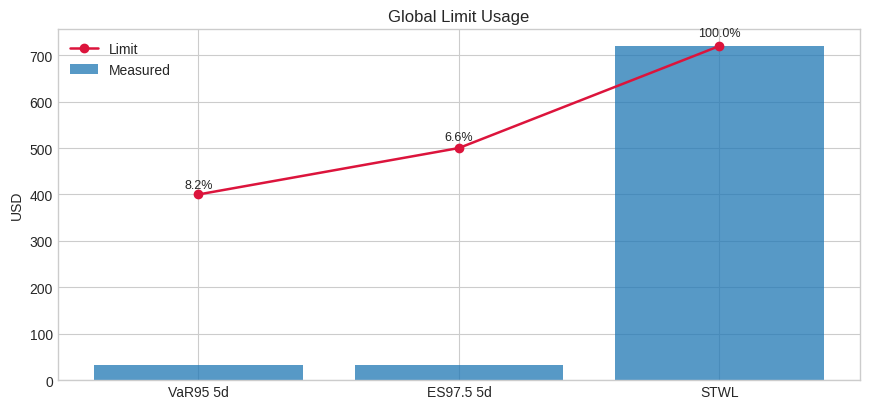

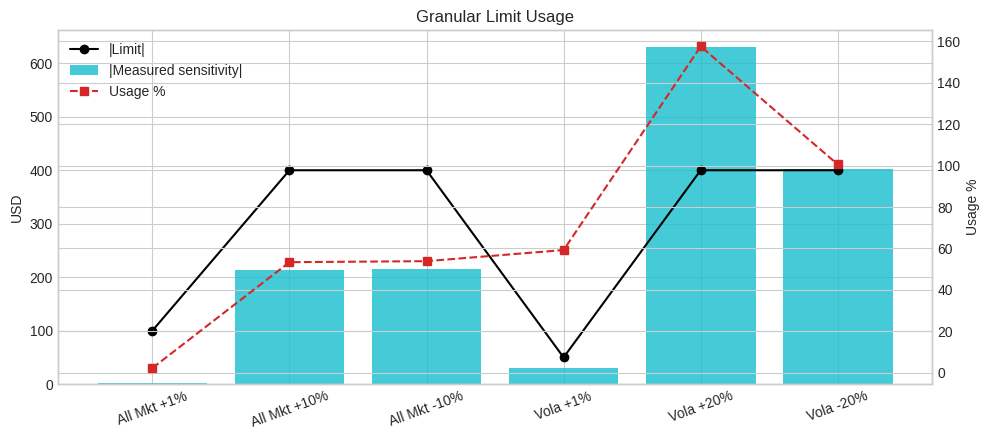

In [19]:
# Extended Risk Dashboard (graph-only)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Global limits usage chart ----
if all(v in globals() for v in ['VaR_Loss', 'ES_Loss', 'var_limit', 'es_limit']):
    stwl_measured = float(limit_stwl) if 'stwl_limit' in globals() else (float(abs(stress_df['P&L'].min())) if 'stress_df' in globals() and len(stress_df)>0 else np.nan)
    stwl_limit_plot = stwl_measured if np.isfinite(stwl_measured) and stwl_measured > 0 else np.nan

    metrics = ['VaR95 5d', 'ES97.5 5d', 'STWL']
    measured = [float(VaR_Loss), float(ES_Loss), stwl_measured]
    limits = [float(var_limit), float(es_limit), stwl_limit_plot]

    x = np.arange(len(metrics))
    plt.figure(figsize=(8.8, 4.2))
    plt.bar(x, measured, color='tab:blue', alpha=0.75, label='Measured')
    plt.plot(x, limits, color='crimson', marker='o', lw=1.8, label='Limit')
    for i, (m, l) in enumerate(zip(measured, limits)):
        if np.isfinite(m) and np.isfinite(l) and l != 0:
            plt.text(i, max(m, l)*1.02, f'{100*m/l:.1f}%', ha='center', va='bottom', fontsize=9)
    plt.xticks(x, metrics)
    plt.ylabel('USD')
    plt.title('Global Limit Usage')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Granular limit usage chart ----
gran_ok = all(v in globals() for v in ['pnl_p1','pnl_p10','pnl_m10','pnl_vp1','pnl_vp20','pnl_vm20','plus_1pct_all_mkt_limit','plus_10pct_all_mkt_limit','minus_10pct_all_mkt_limit','plus_1pct_vol_limit','plus_20pct_vol_limit','minus_20pct_vol_limit'])
if gran_ok:
    labels = ['All Mkt +1%','All Mkt +10%','All Mkt -10%','Vola +1%','Vola +20%','Vola -20%']
    measured = np.array([pnl_p1,pnl_p10,pnl_m10,pnl_vp1,pnl_vp20,pnl_vm20], dtype=float)
    limits = np.array([plus_1pct_all_mkt_limit,plus_10pct_all_mkt_limit,minus_10pct_all_mkt_limit,plus_1pct_vol_limit,plus_20pct_vol_limit,minus_20pct_vol_limit], dtype=float)
    usage = np.where(np.abs(limits)>1e-12, 100*np.abs(measured)/np.abs(limits), np.nan)

    fig, ax1 = plt.subplots(figsize=(10,4.5))
    ax1.bar(labels, np.abs(measured), color='tab:cyan', alpha=0.8, label='|Measured sensitivity|')
    ax1.plot(labels, np.abs(limits), color='black', marker='o', lw=1.5, label='|Limit|')
    ax1.set_ylabel('USD')
    ax1.set_title('Granular Limit Usage')
    ax1.tick_params(axis='x', rotation=20)

    ax2 = ax1.twinx()
    ax2.plot(labels, usage, color='tab:red', marker='s', lw=1.5, linestyle='--', label='Usage %')
    ax2.set_ylabel('Usage %')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper left')
    plt.tight_layout()
    plt.show()


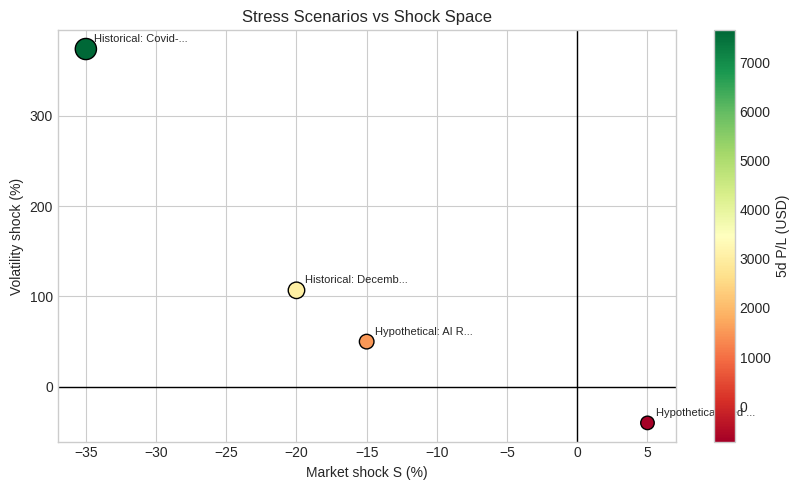

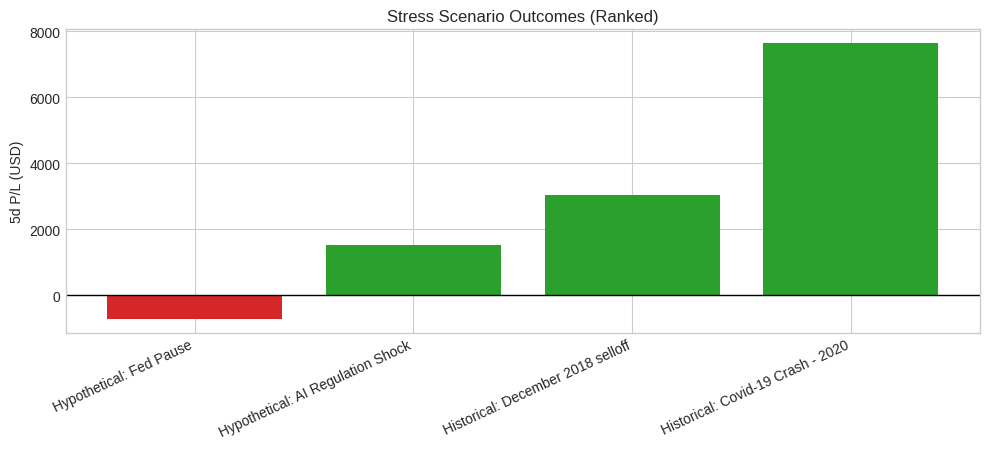

In [20]:
# Stress Map and Ranking (graph-only)

if 'stress_df' in globals() and len(stress_df) > 0:
    df = stress_df.copy()

    # Parse percentage strings like '-35.0%' into decimals
    def parse_pct(x):
        try:
            s = str(x).replace('%','').replace('+','').strip()
            return float(s)/100.0
        except Exception:
            return np.nan

    s_col = 'S_Shock' if 'S_Shock' in df.columns else ('S_shock' if 'S_shock' in df.columns else None)
    v_col = 'Vol_Shock' if 'Vol_Shock' in df.columns else ('Vol_shock' if 'Vol_shock' in df.columns else None)
    p_col = 'P&L' if 'P&L' in df.columns else ('P/L' if 'P/L' in df.columns else None)

    if s_col and v_col and p_col:
        df['_S'] = df[s_col].map(parse_pct)
        df['_V'] = df[v_col].map(parse_pct)
        df['_P'] = pd.to_numeric(df[p_col], errors='coerce')

        # (1) Stress scenario map
        plt.figure(figsize=(8.5, 5.0))
        sc = plt.scatter(100*df['_S'], 100*df['_V'], c=df['_P'], s=80 + 0.02*np.abs(df['_P']), cmap='RdYlGn', edgecolors='black')
        for _, r in df.iterrows():
            lbl = str(r['Scenario'])[:18] + ('...' if len(str(r['Scenario']))>18 else '')
            plt.annotate(lbl, (100*r['_S'], 100*r['_V']), xytext=(6,5), textcoords='offset points', fontsize=8)
        plt.axhline(0, color='black', lw=1)
        plt.axvline(0, color='black', lw=1)
        plt.colorbar(sc, label='5d P/L (USD)')
        plt.xlabel('Market shock S (%)')
        plt.ylabel('Volatility shock (%)')
        plt.title('Stress Scenarios vs Shock Space')
        plt.tight_layout()
        plt.show()

        # (2) Ranked stress outcomes
        dfr = df.sort_values('_P')
        colors = ['tab:red' if x < 0 else 'tab:green' for x in dfr['_P']]
        plt.figure(figsize=(10,4.6))
        plt.bar(dfr['Scenario'], dfr['_P'], color=colors)
        plt.axhline(0, color='black', lw=1)
        plt.xticks(rotation=25, ha='right')
        plt.ylabel('5d P/L (USD)')
        plt.title('Stress Scenario Outcomes (Ranked)')
        plt.tight_layout()
        plt.show()


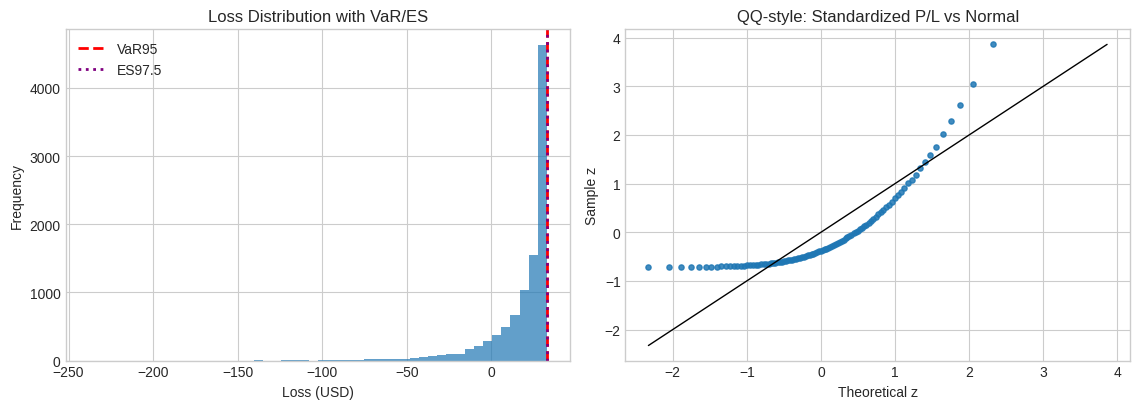

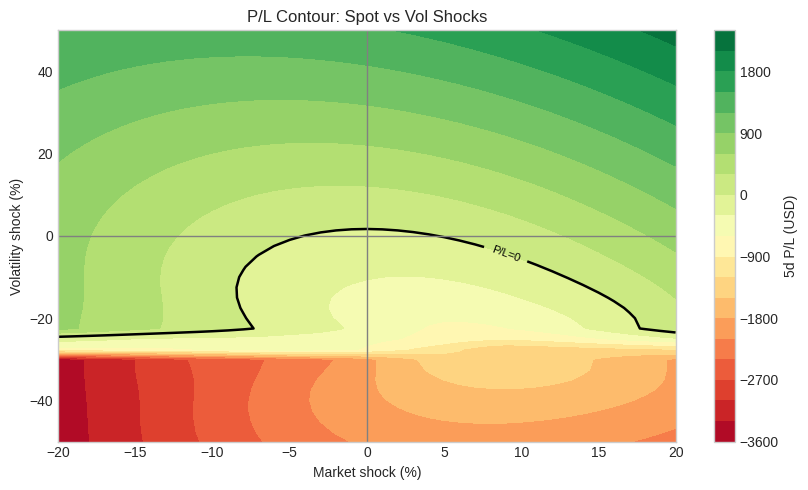

In [21]:
# Tail Diagnostics and Scenario Contour (graph-only)

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# ---- Tail diagnostics from MC P/L ----
if 'P_L_sim' in globals():
    pnl = np.asarray(P_L_sim, dtype=float)
    loss = -pnl

    fig, axs = plt.subplots(1, 2, figsize=(11.5, 4.2))

    # Left: loss distribution + VaR/ES
    axs[0].hist(loss, bins=50, alpha=0.7, color='tab:blue')
    if 'VaR_Loss' in globals():
        axs[0].axvline(float(VaR_Loss), color='red', ls='--', lw=2, label='VaR95')
    if 'ES_Loss' in globals():
        axs[0].axvline(float(ES_Loss), color='purple', ls=':', lw=2, label='ES97.5')
    axs[0].set_title('Loss Distribution with VaR/ES')
    axs[0].set_xlabel('Loss (USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()

    # Right: QQ-style standardized P/L
    mu, sd = float(np.mean(pnl)), float(np.std(pnl, ddof=1))
    z = (pnl - mu) / sd if sd > 1e-12 else pnl * 0.0
    q = np.linspace(0.01, 0.99, 99)
    theo = stats.norm.ppf(q)
    samp = np.quantile(z, q)
    axs[1].scatter(theo, samp, s=14, alpha=0.85)
    lo = min(theo.min(), samp.min()); hi = max(theo.max(), samp.max())
    axs[1].plot([lo, hi], [lo, hi], 'k-', lw=1)
    axs[1].set_title('QQ-style: Standardized P/L vs Normal')
    axs[1].set_xlabel('Theoretical z')
    axs[1].set_ylabel('Sample z')

    plt.tight_layout()
    plt.show()

# ---- 2D contour of P/L over (spot, vol) ----
if all(k in globals() for k in ['strategy','S0','delta_tot','value_hedged','Hedged_portfolio_value_both']):
    s_shock = np.linspace(-0.20, 0.20, 41)
    v_shock = np.linspace(-0.50, 0.50, 41)
    ZZ = np.zeros((len(v_shock), len(s_shock)))
    end = datetime(2026, 2, 6)
    for i, dv in enumerate(v_shock):
        for j, ds in enumerate(s_shock):
            ZZ[i, j] = Hedged_portfolio_value_both(strategy, S0*(1+ds), dv, end, delta_tot) - value_hedged

    X, Y = np.meshgrid(100*s_shock, 100*v_shock)
    plt.figure(figsize=(8.5, 5.0))
    cs = plt.contourf(X, Y, ZZ, levels=18, cmap='RdYlGn')
    plt.colorbar(cs, label='5d P/L (USD)')
    c0 = plt.contour(X, Y, ZZ, levels=[0.0], colors='black', linewidths=1.8)
    plt.clabel(c0, fmt='P/L=0', fontsize=8)
    plt.axhline(0, color='gray', lw=1)
    plt.axvline(0, color='gray', lw=1)
    plt.xlabel('Market shock (%)')
    plt.ylabel('Volatility shock (%)')
    plt.title('P/L Contour: Spot vs Vol Shocks')
    plt.tight_layout()
    plt.show()


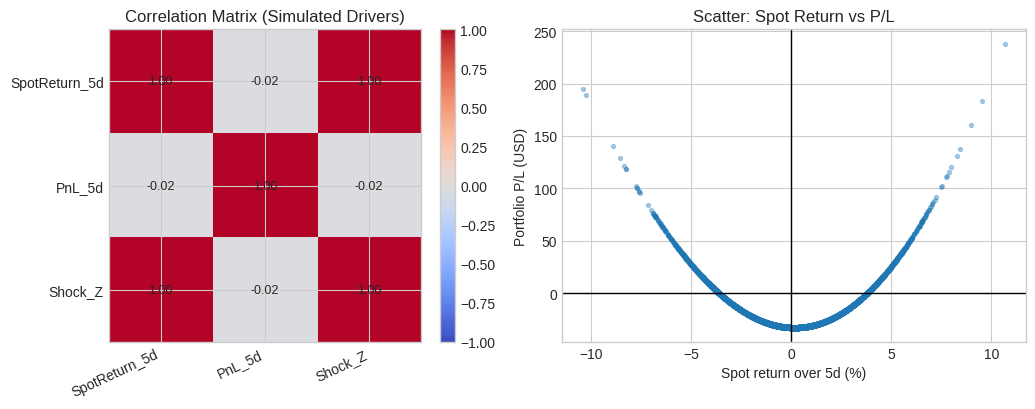

In [22]:
# Driver Correlation and Scatter (graph-only)
if all(v in globals() for v in ['P_L_sim', 'S_sim', 'S0']):
    df_drv = pd.DataFrame({
        'SpotReturn_5d': np.log(np.asarray(S_sim, dtype=float) / float(S0)),
        'PnL_5d': np.asarray(P_L_sim, dtype=float),
    })
    if 'Z' in globals():
        df_drv['Shock_Z'] = np.asarray(Z, dtype=float)

    corr = df_drv.corr(numeric_only=True)

    fig, axs = plt.subplots(1, 2, figsize=(11.2, 4.2))

    # Correlation matrix heatmap (matplotlib only)
    im = axs[0].imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
    axs[0].set_xticks(np.arange(len(corr.columns)))
    axs[0].set_yticks(np.arange(len(corr.index)))
    axs[0].set_xticklabels(corr.columns, rotation=25, ha='right')
    axs[0].set_yticklabels(corr.index)
    axs[0].set_title('Correlation Matrix (Simulated Drivers)')
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            axs[0].text(j, i, f'{corr.values[i,j]:.2f}', ha='center', va='center', fontsize=9)
    fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)

    # Scatter: simulated spot return vs P/L
    axs[1].scatter(100*df_drv['SpotReturn_5d'], df_drv['PnL_5d'], s=8, alpha=0.35)
    axs[1].axhline(0, color='black', lw=1)
    axs[1].axvline(0, color='black', lw=1)
    axs[1].set_xlabel('Spot return over 5d (%)')
    axs[1].set_ylabel('Portfolio P/L (USD)')
    axs[1].set_title('Scatter: Spot Return vs P/L')

    plt.tight_layout()
    plt.show()
else:
    print('Skip driver correlation/scatter: requires P_L_sim and S_sim from MC cell.')


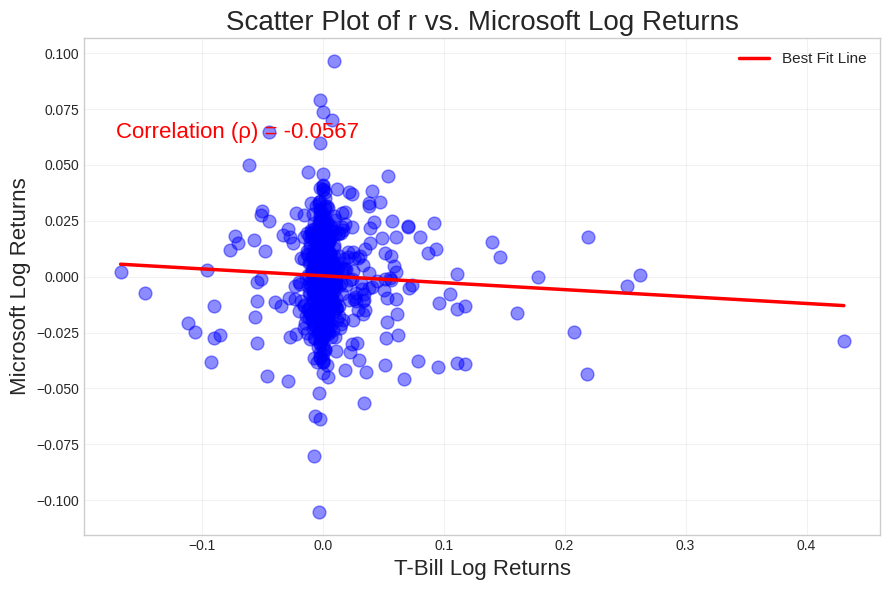

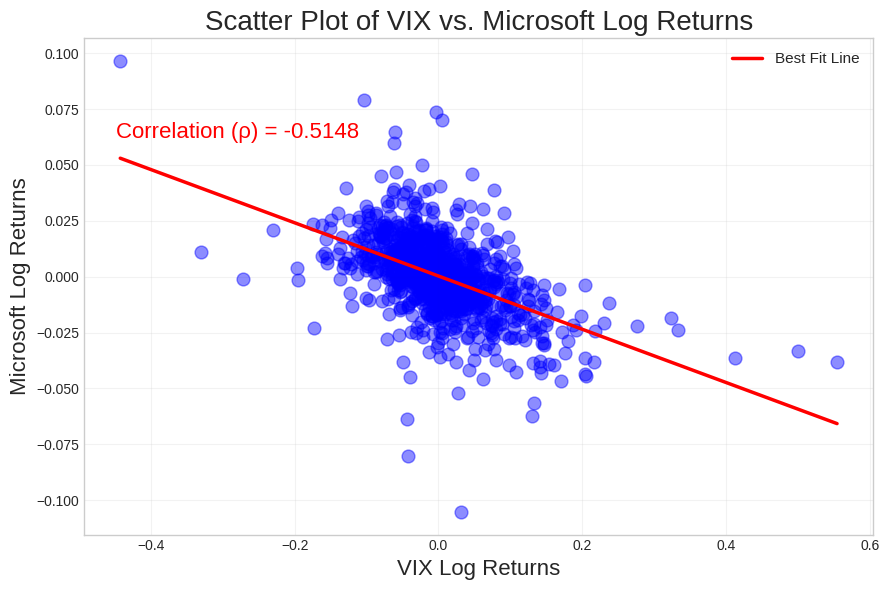

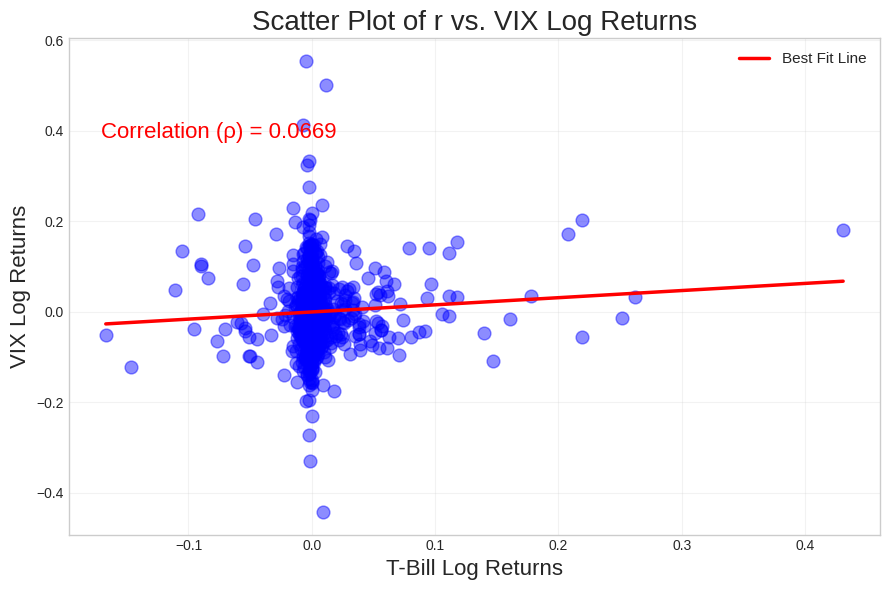

In [23]:
# Scatter Diagnostics: r, VIX, and Microsoft Log Returns (graph-only)

if 'valuation_date' in globals():
    end_dt = pd.Timestamp(valuation_date)
else:
    end_dt = pd.Timestamp.today()
start_dt = pd.Timestamp('2022-01-01')

# Download aligned market series
msft_close = yf.download('MSFT', start=start_dt, end=end_dt + pd.Timedelta(days=1), auto_adjust=True, progress=False)['Close']
msft_close.name = 'MSFT'

vix_temp_df = yf.download('^VIX', start=start_dt, end=end_dt + pd.Timedelta(days=1), auto_adjust=True, progress=False)
vix_close_series = pd.Series(dtype=float) # Initialize as empty
if 'Close' in vix_temp_df.columns:
    vix_close_series = vix_temp_df['Close']
elif not vix_temp_df.empty and len(vix_temp_df.columns) > 0:
    # Fallback to the first column if 'Close' is not found
    vix_close_series = vix_temp_df.iloc[:, 0]
else:
    print("Warning: VIX data could not be retrieved, 'VIX' column might be empty.")
vix_close_series.name = 'VIX'

if 'pdr' not in globals() or pdr is None:
    import pandas_datareader.data as pdr

r_df = pdr.DataReader('DGS3MO', 'fred', start=start_dt, end=end_dt + pd.Timedelta(days=1)).ffill()
r_series = pd.to_numeric(r_df.iloc[:, 0], errors='coerce') / 100.0
r_series.name = 'R'

# Create a DataFrame from the Series, aligning indices explicitly
temp_df = pd.DataFrame(index=msft_close.index) # Use MSFT index as a base for alignment
temp_df['MSFT'] = msft_close
temp_df['VIX'] = vix_close_series
temp_df['R'] = r_series

ret_df = temp_df.dropna() # Drop rows with any NaN

# For log returns we keep strictly positive levels
ret_df = ret_df[(ret_df[['MSFT', 'VIX', 'R']] > 0).all(axis=1)]
log_ret = np.log(ret_df / ret_df.shift(1)).dropna()
log_ret = log_ret.replace([np.inf, -np.inf], np.nan).dropna()


def scatter_with_fit(x, y, xlabel, ylabel, title):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    if len(x) < 3:
        print(f'Skip {title}: not enough points')
        return

    rho = float(np.corrcoef(x, y)[0, 1])
    beta, alpha = np.polyfit(x, y, 1)
    xx = np.linspace(x.min(), x.max(), 200)
    yy = beta * xx + alpha

    plt.figure(figsize=(9, 6))
    plt.scatter(x, y, color='blue', alpha=0.45, s=85)
    plt.plot(xx, yy, color='red', lw=2.5, label='Best Fit Line')
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc='upper right', fontsize=11)
    plt.text(0.04, 0.80, f'Correlation (ρ) = {rho:.4f}', transform=plt.gca().transAxes,
             color='red', fontsize=16)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


scatter_with_fit(
    log_ret['R'], log_ret['MSFT'],
    'T-Bill Log Returns', 'Microsoft Log Returns',
    'Scatter Plot of r vs. Microsoft Log Returns'
)

scatter_with_fit(
    log_ret['VIX'], log_ret['MSFT'],
    'VIX Log Returns', 'Microsoft Log Returns',
    'Scatter Plot of VIX vs. Microsoft Log Returns'
)

scatter_with_fit(
    log_ret['R'], log_ret['VIX'],
    'T-Bill Log Returns', 'VIX Log Returns',
    'Scatter Plot of r vs. VIX Log Returns'
)
